In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import fisher_exact

from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [59]:
haplodat = pd.read_csv('./haplotype_snps_r.tsv', sep='\t', index_col=0)
ind = haplodat['ID'] == '.'
haplodat.loc[ind, 'ID'] = 'chr22:'  + haplodat.loc[ind, 'POS'].astype(str)
haplodat['r_kmeansleft_abs'] = haplodat['r_kmeansleft'].abs()
haplodat['r_kmeans_abs'] = haplodat['r_kmeans'].abs()

haplodat.head()

,ALT,CHROM,FILTER,ID,INFO,POS,QUAL,REF,AF,r_kmeans,r_kmeansleft,r_kmeansleft_abs,r_kmeans_abs
8,C,22,PASS,rs12484476,.,33600759,100,T,0.371575,-0.062229,-0.181480,0.181480,0.062229
13,GA,22,PASS,rs61422535,.,33601022,100,G,0.371575,-0.062229,-0.181480,0.181480,0.062229
44,T,22,PASS,rs148574485,.,33602237,100,C,0.234589,0.051354,0.325453,0.325453,0.051354
51,C,22,PASS,rs68072541,.,33602373,100,T,0.371575,-0.062229,-0.181480,0.181480,0.062229
63,G,22,PASS,rs16991966,.,33602984,100,A,0.357877,-0.095538,-0.176232,0.176232,0.095538


In [60]:
haplodat['POS'].min(), haplodat['POS'].max()

(33600759, 34499558)

In [61]:
haplodat['AF'].min(), haplodat['AF'].max()

(0.051369863013698634, 0.9486301369863014)

In [63]:
ind = ((haplodat['r_kmeans_abs']>.15) | (haplodat['r_kmeansleft_abs']>.15))
ind.value_counts()

False    1743
True     1674
dtype: int64

In [6]:
largeP = pd.ExcelFile('../../data/tmp/LARGE/MPRA/LARGE_MPRA.xlsx').parse('largeP', skiprows=3)
largeP = pd.merge(left=oligoinfo[['oligoid', 'orig_oligoid', 'varid']], right=largeP, left_on='oligoid', right_on='SeqName', how='right')
largeP = largeP.loc[~largeP['oligoid'].isnull(),:]
largeP['PosID'] = largeP['orig_oligoid'].apply(lambda x: ':'.join(x.split(':')[:2]))
largeP['Mid'] = largeP['orig_oligoid'].apply(lambda x: x.split(':')[1]).astype(int)

largeP.head()

,oligoid,orig_oligoid,varid,SeqName,olgio#,baseMean_Ref,log2FoldChange_Ref,lfcSE_Ref,stat_Ref,pvalue_Ref,...,Skew_P_Val,Skew_P_Val_Adj,is enhancer?,is skewed?,Enhancer and skew?,chr,start,end,PosID,Mid
0,5860set_5overlaps_oligo2,chr22:33600759:C,rs12484476,5860set_5overlaps_oligo2,2.0,584.938659,-0.311199,0.511292,-0.608652,0.542755,...,0.766757,0.997641,0,0,0,chr22,33204674.0,33204874.0,chr22:33600759,33600759
1,5860set_5overlaps_oligo4,chr22:33601022:A,rs61422535,5860set_5overlaps_oligo4,4.0,55.936043,-0.887185,1.328780,-0.667668,0.504345,...,0.252719,0.986873,0,0,0,chr22,33204942.0,33205142.0,chr22:33601022,33601022
2,5860set_5overlaps_oligo6,chr22:33602237:T,rs148574485,5860set_5overlaps_oligo6,6.0,1408.021029,-1.107229,0.340179,-3.254839,0.001135,...,0.229778,0.979257,1,0,0,chr22,33206152.0,33206352.0,chr22:33602237,33602237
3,5860set_5overlaps_oligo8,chr22:33602373:C,rs68072541,5860set_5overlaps_oligo8,8.0,961.368875,0.166051,0.273086,0.608054,0.543152,...,0.851192,0.997641,0,0,0,chr22,33206288.0,33206488.0,chr22:33602373,33602373
4,5860set_5overlaps_oligo10,chr22:33602984:G,rs16991966,5860set_5overlaps_oligo10,10.0,50.011004,-2.642850,0.919481,-2.874284,0.004049,...,0.002102,0.076253,0,0,0,chr22,33206899.0,33207099.0,chr22:33602984,33602984


In [11]:
hapcorr = pd.read_csv('../../data/tmp/LARGE/LARGE_Haplotype_Associated_Variants_Dprime_R_WiderRegionForMPRA20220226.tsv', sep='\t', index_col=0)
#hapcorr = pd.read_csv('../../data/tmp/LARGE/LARGE_Haplotype_Associated_Variants_Dprime_R.tsv', sep='\t', index_col=0)
#hapcorr['POS'] = [int(x.split(':')[1].split('[')[0]) for x in hapcorr.index]
hapcorr['PosID'] = ['chr' + x for x in hapcorr.index]
hapcorr['POS'] = hapcorr['POS'].astype(int)
hapcorr.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,Haplotype_R,Haplotype_Dprime,PosID
22:33500203,22,33500203,rs73393700,G,A,.,PASS,TYPED;RefPanelAF=0.0968523;AN=11110;AC=1087;IN...,0.029655,0.045700,chr22:33500203
22:33500311,22,33500311,rs137296,G,A,.,PASS,TYPED;RefPanelAF=0.101796;AN=11110;AC=405;INFO=1,0.004267,0.010993,chr22:33500311
22:33500524,22,33500524,rs73393702,G,C,.,PASS,RefPanelAF=0.00443906;AN=11110;AC=155;INFO=0.8...,0.000183,0.000901,chr22:33500524
22:33500788,22,33500788,rs144258801,C,T,.,PASS,RefPanelAF=0.00696126;AN=11110;AC=95;INFO=0.93...,-0.018300,0.432466,chr22:33500788
22:33501145,22,33501145,rs145124451,C,T,.,PASS,RefPanelAF=0.0146287;AN=11110;AC=480;INFO=0.89...,-0.010181,0.096843,chr22:33501145


In [12]:
largeP['POS'] = largeP['orig_oligoid'].apply(lambda x: x.split(':')[1]).astype(int)

In [13]:
largeP['POS'].isin(hapcorr['POS']).value_counts()

True     2437
False     493
Name: POS, dtype: int64

In [14]:
largeP['PosID'].isin(hapcorr['PosID']).value_counts()

True     2437
False     493
Name: PosID, dtype: int64

In [15]:
largeP['varid'].isin(hapcorr['ID']).value_counts()

True     2439
False     491
Name: varid, dtype: int64

In [16]:
(largeP['POS'].isin(hapcorr['POS']) | largeP['varid'].isin(hapcorr['ID'])).value_counts()

True     2493
False     437
dtype: int64

In [17]:
ind = largeP['varid'].isin(hapcorr['ID']) & ~largeP['PosID'].isin(hapcorr['PosID'])
largeP.loc[ind, 'varid'].value_counts()

.    56
Name: varid, dtype: int64

In [18]:
largeP_merge = pd.merge(left=largeP, right=hapcorr[['PosID', 'Haplotype_R', 'Haplotype_Dprime', 'ID']], on='PosID', how='left' )

In [19]:
largeP_merge['Abs_Haplotype_R'] = largeP_merge['Haplotype_R'].abs()

In [20]:
largeP_merge['Mid'].min(), largeP_merge['Mid'].max()

(33600759, 34495816)

In [22]:
largeP_merge['log_skew_P'] = largeP_merge.loc[:, 'Skew_P_Val_Adj'].astype(float).apply(np.log10)*-1


In [24]:
largeP_merge.loc[largeP_merge['Abs_Haplotype_R']>.6, :].sort_values(by='log_skew_P', ascending=False)[['varid', 'PosID', 'Abs_Haplotype_R', 'Haplotype_Dprime', 'Skew_P_Val_Adj']].head(5)

,varid,PosID,Abs_Haplotype_R,Haplotype_Dprime,Skew_P_Val_Adj
2546,rs738948,chr22:34227108,0.633005,0.875707,0.000007
2442,rs16993101,chr22:34220707,0.678799,0.955680,0.000022
2619,rs738949,chr22:34238465,0.791497,0.869220,0.000112
2568,rs58484073,chr22:34230571,0.780510,0.796169,0.001567
2519,rs9607079,chr22:34226582,0.706208,0.910945,0.001750


In [27]:
largeP_merge.loc[largeP_merge['Abs_Haplotype_R']>.9, :].sort_values(by='Skew_P_Val', ascending=False)[['varid', 'PosID', 'Abs_Haplotype_R', 'Haplotype_Dprime', 'Skew_P_Val', 'Skew_P_Val_Adj']].head(5)

,varid,PosID,Abs_Haplotype_R,Haplotype_Dprime,Skew_P_Val,Skew_P_Val_Adj
2274,rs59015613,chr22:34172398,0.925261,0.955252,0.971571,0.997641
2503,rs73404896,chr22:34225513,0.901082,0.906404,0.945428,0.997641
2504,rs73404896,chr22:34225513,0.901082,0.906404,0.727566,0.997641
651,rs16993014,chr22:34174184,0.924667,0.954054,0.656028,0.997641
707,rs8135517,chr22:34211867,0.920445,0.950280,0.584521,0.997641


In [26]:
largeP_merge.columns

Index(['oligoid', 'orig_oligoid', 'varid', 'SeqName', 'olgio#', 'baseMean_Ref',
       'log2FoldChange_Ref', 'lfcSE_Ref', 'stat_Ref', 'pvalue_Ref', 'padj_Ref',
       'baseMean_Alt', 'log2FoldChange_Alt', 'lfcSE_Alt', 'stat_Alt',
       'pvalue_Alt', 'padj_Alt', 'logFCDifferences',
       'logFCDifferencesNormalized_WithNonActive', 'Skew_P_Val',
       'Skew_P_Val_Adj', 'is enhancer?', 'is skewed? ', 'Enhancer and skew?',
       'chr', 'start', 'end', 'PosID', 'Mid', 'POS', 'Haplotype_R',
       'Haplotype_Dprime', 'ID', 'Abs_Haplotype_R', 'log_skew_P'],
      dtype='object')

/opt/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:92: UserWarning: Use the colorbar set_ticks() method instead.


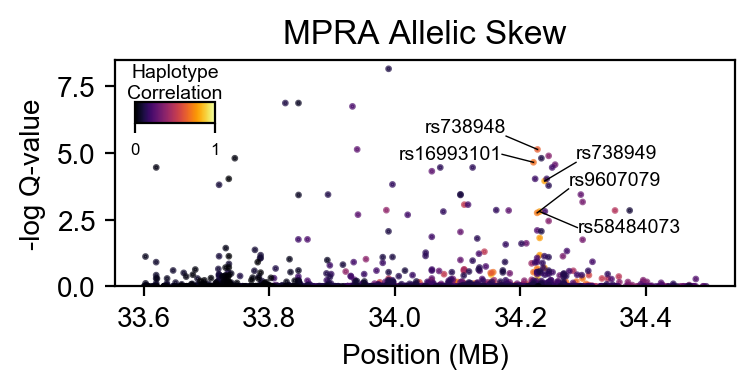

In [142]:
(fig,ax) = plt.subplots(1,1, figsize=(4,1.5), dpi=200)
ind = largeP_merge['Haplotype_R'].isnull()
#ax.scatter(largeP_merge.loc[ind, 'Mid']/(10**6), largeP_merge.loc[ind, 'Skew_P_Val_Adj'].astype(float).apply(np.log10)*-1, color='gray')
#ax.scatter(largeP_merge.loc[~ind, 'start']/(10**6), largeP_merge.loc[~ind, 'Skew_P_Val_Adj'].astype(float).apply(np.log10)*-1, color='b')
largeP_merge = largeP_merge.sort_values(by='Abs_Haplotype_R', ascending=False)

#im = ax.scatter(largeP_merge.loc[~ind, 'Mid']/(10**6),
#               largeP_merge.loc[~ind, 'log_skew_P'],
#               c=largeP_merge.loc[~ind, 'Haplotype_R'],
#                s=2, cmap='bwr',vmin=-1, vmax=1)

im = ax.scatter(largeP_merge.loc[~ind, 'Mid']/(10**6),
               largeP_merge.loc[~ind, 'log_skew_P'],
               c=largeP_merge.loc[~ind, 'Abs_Haplotype_R'],
                s=2, cmap='inferno',vmin=0, vmax=1, alpha=.7)
labfs=7

v =2546
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) - .05,
        y=largeP_merge.loc[v, 'log_skew_P']+.5,
        s=largeP_merge.loc[v, 'ID'],
       ha='right', va='bottom', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) - .05],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+.5], color='k', linewidth=.5)

v =2442
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) - .05,
        y=largeP_merge.loc[v, 'log_skew_P']+.3,
        s=largeP_merge.loc[v, 'ID'],
       ha='right', va='center', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) - .05],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+.3], color='k', linewidth=.5)

v=2568
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) + .06,
        y=largeP_merge.loc[v, 'log_skew_P']-.6,
        s=largeP_merge.loc[v, 'ID'],
       ha='left', va='center', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) + .06],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']-.6], color='k', linewidth=.5)

v=2619
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) + .05,
        y=largeP_merge.loc[v, 'log_skew_P']+.7,
        s=largeP_merge.loc[v, 'ID'],
       ha='left', va='bottom', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) + .05],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+.7], color='k', linewidth=.5)


v =2519
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) + .05,
        y=largeP_merge.loc[v, 'log_skew_P']+.9,
        s=largeP_merge.loc[v, 'ID'],
       ha='left', va='bottom', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) + .05],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+.9], color='k', linewidth=.5)

'''
v = 2497
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) + .08,
        y=largeP_merge.loc[v, 'log_skew_P']+1,
        s=largeP_merge.loc[v, 'ID'],
       ha='left', va='bottom', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) + .08],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+1], color='k', linewidth=.5)

v = 814
ax.text(x=largeP_merge.loc[v, 'Mid']/(10**6) + .08,
        y=largeP_merge.loc[v, 'log_skew_P']+1,
        s=largeP_merge.loc[v, 'ID'],
       ha='left', va='bottom', fontsize=labfs)

ax.plot([largeP_merge.loc[v, 'Mid']/(10**6), largeP_merge.loc[v, 'Mid']/(10**6) + .08],
       [largeP_merge.loc[v, 'log_skew_P'], largeP_merge.loc[v, 'log_skew_P']+1], color='k', linewidth=.5)
'''

ax.set_xlabel('Position (MB)', fontsize=10)
ax.set_ylabel('-log Q-value', fontsize=10)
ax.set_title('MPRA Allelic Skew', fontsize=12)
ax.set_ylim([0,8.5])
cbar_ax = fig.add_axes([.15,.67, .1, .07])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title('Haplotype\nCorrelation', fontsize=7, pad=.2)
cbar_ax.set_xticks([0,1])

cbar_ax.set_xticklabels([0,1], fontsize=6)

plt.savefig('../../figures/MPRA_scatter.png', bbox_inches='tight')
plt.savefig('../../figures/MPRA_scatter.pdf', bbox_inches='tight')

In [84]:
largeP_merge['varid'].unique().shape

(1646,)

In [85]:
(largeP_merge['Skew_P_Val_Adj']<.05).value_counts()

False    2865
True       65
Name: Skew_P_Val_Adj, dtype: int64

In [86]:
minqpervar = largeP_merge[['PosID', 'Skew_P_Val_Adj']].groupby('PosID')['Skew_P_Val_Adj'].min()

In [88]:
(minqpervar<.05).value_counts()

False    1615
True       59
Name: Skew_P_Val_Adj, dtype: int64

In [97]:
ind = (largeP_merge['Skew_P_Val_Adj']<.01) & (largeP_merge['Haplotype_R']>.6)
largeP_merge.loc[ind, ['ID', 'Haplotype_R', 'Haplotype_Dprime', 'Skew_P_Val_Adj']].sort_values(by='Skew_P_Val_Adj')

,ID,Haplotype_R,Haplotype_Dprime,Skew_P_Val_Adj
2546,rs738948,0.633005,0.875707,0.000007
2442,rs16993101,0.678799,0.955680,0.000022
2619,rs738949,0.791497,0.869220,0.000112
2568,rs58484073,0.780510,0.796169,0.001567
2519,rs9607079,0.706208,0.910945,0.001750


In [100]:
largeP_merge.loc[ind, ['ID', 'Haplotype_R', 'Haplotype_Dprime', 'Skew_P_Val_Adj']].sort_values(by='Skew_P_Val_Adj')['ID'].values

array(['rs738948', 'rs16993101', 'rs738949', 'rs58484073', 'rs9607079'],
      dtype=object)